In [1]:
import pandas as pd
import numpy as np
import torch
import torchsde
import matplotlib.pyplot as plt

/Users/vitorihaldijiran/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/vitorihaldijiran/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the dataset
file_path = 'AirQualityUCI.csv'
data = pd.read_csv(file_path, sep=';', decimal=',')

# Replace missing values with NaN
data.replace(-200, np.nan, inplace=True)

# Drop columns with a significant number of missing values
data.dropna(axis=1, thresh=int(0.5 * len(data)), inplace=True)

# Drop rows with any remaining missing values
data.dropna(axis=0, inplace=True)

# Select relevant columns
selected_columns = [
    'CO(GT)', 'C6H6(GT)'
]
data_selected = data[selected_columns]

# Normalize the data
data_normalized = (data_selected - data_selected.mean()) / data_selected.std()

In [3]:
# Define the SDE model
class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'
    
    def __init__(self, state_size):
        super().__init__()
        self.mu = torch.nn.Parameter(torch.zeros(state_size))
        self.sigma = torch.nn.Parameter(torch.eye(state_size) * 0.1)

    def f(self, t, y):
        batch_size = y.size(0)
        return self.mu.expand(batch_size, -1)

    def g(self, t, y):
        batch_size = y.size(0)
        return self.sigma.expand(batch_size, -1, -1)

# Create the SDE model
state_size = len(selected_columns)
sde = SDE(state_size)

# Convert the data to PyTorch tensors
data_tensor = torch.tensor(data_normalized.values, dtype=torch.float32)

# Define the initial condition and the time points
y0 = data_tensor[0].unsqueeze(0)  # Add batch dimension
ts = torch.linspace(0, 1, len(data_tensor))

# Solve the SDE
solution = torchsde.sdeint(sde, y0, ts)

# Convert the solution to a NumPy array for visualization
solution_np = solution.squeeze(1).detach().numpy()  # Remove batch dimension for plotting

In [4]:
solution

tensor([[[0.2897, 0.1802]],

        [[0.2898, 0.1802]],

        [[0.2898, 0.1801]],

        ...,

        [[0.3218, 0.0962]],

        [[0.3220, 0.0961]],

        [[0.3223, 0.0959]]], grad_fn=<StackBackward0>)

In [5]:
solution_np

array([[0.28972086, 0.1802373 ],
       [0.28977376, 0.18016887],
       [0.2898267 , 0.18010047],
       ...,
       [0.32181966, 0.09622669],
       [0.32200003, 0.09614949],
       [0.32229024, 0.09591778]], dtype=float32)

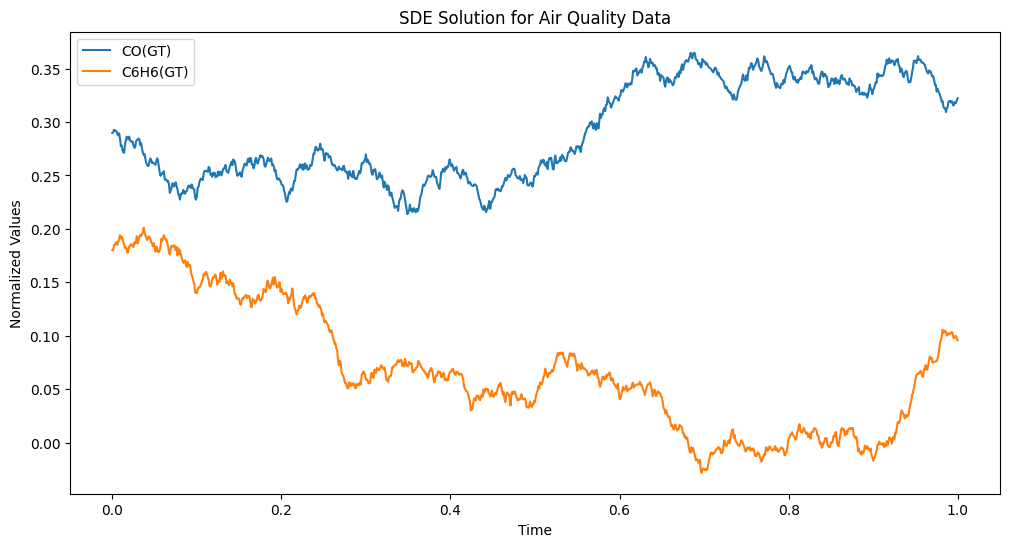

In [6]:
# Plot the solution
plt.figure(figsize=(12, 6))
plt.plot(ts.numpy(), solution_np[:, 0], label='CO(GT)')
plt.plot(ts.numpy(), solution_np[:, 1], label='C6H6(GT)')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.title('SDE Solution for Air Quality Data')
plt.legend()
plt.show()